In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as n
import os.path
import datetime as dt

from imp import reload

from modules import thermal
import copy
import csv

Populating the interactive namespace from numpy and matplotlib


In [79]:
# dt is always in seconds

class Satellite():
    def __init__(self, temp_str = 275, temp_pay = 275, temp_bat = 275, battery_charge_frac=1.0):
        
        # break this out later
        self.battery_capacity_mAh = 20000.0
        self.converter_efficiency = 0.8
        
        
        # mission timings
        self.beacon_interval = 60
        self.beacon_duration = 1
        self.passover_interval = 90*60
        self.passover_duration_exp_off = 10*60
        self.passover_duration_exp_on = 1*60
        self.exp_start_time = 11 * 60 * 60
        self.exp_duration = 2 * 24 * 60 * 60
        self.heater_setpoints = {'payload' : 273.15 + 30.0, 'battery' : 273.15 + 30.0 }
        
        # initialize state
        self.charge = self.battery_capacity_mAh * battery_charge_frac
        self.temperatures = {'battery' : temp_bat, 'structure' : temp_str, 'payload' :  temp_pay}
        self.qdots = {'battery' : 0, 'structure' : 0, 'payload' : 0}
        self.solar_shunts = False
        
        # create the loads
        self.beacon =        {'state': False, 'i': 1000 ,   'v': 5.0, 'name' : 'Beacon'    , 'inst_current': 0}
        self.passover =      {'state': False, 'i': 1000 ,   'v': 5.0, 'name' : 'Passover'  , 'inst_current': 0}
        self.exp =           {'state': False, 'i': 100 ,   'v': 3.3, 'name' : 'Experiment'  , 'inst_current': 0}
        self.batt_heater =   {'state': False, 'i': 250 ,   'v': 5.0, 'name' : 'Battery Heater' , 'inst_current': 0}
        self.pay_heater =    {'state': False, 'i': 500 ,   'v': 5.0, 'name' : 'Payload Heater'  , 'inst_current': 0}
        self.bus_const_pwr = {'state': False , 'i': 200 ,   'v': 3.3, 'name' : 'Bus', 'inst_current': 0}
        
        self.loads = [self.exp, self.bus_const_pwr, self.beacon, self.passover, self.batt_heater, self.pay_heater]
       
        # unit is in mA 
        self.batt_current_in = 0
        self.batt_current_out = 0
        self.batt_current_net = self.batt_current_out - self.batt_current_in
    
    def get_state(self):
        loads = {}
        for load in self.loads:
            loads[load['name']] = (load['state'], load['inst_current'])
        all_state = {
            'loads' : loads,
            'solar_shunts' : self.solar_shunts,
            'temperatures' : self.temperatures,
            'qdots' : self.qdots,
            'batt_current_net' : self.batt_current_net,
            'batt_current_in' : self.batt_current_in,
            'batt_current_out' : self.batt_current_out,
            'batt_v' : self.get_battery_voltage(),
            'batt_charge' : self.charge
        }
        return all_state
        
    def set_state(self, t):       
        # dynamic state variables
        self.batt_heater['state'] = self.temperatures['battery'] < self.heater_setpoints['battery']
        self.pay_heater['state'] = self.temperatures['payload'] < self.heater_setpoints['payload']
        # time based state variables
        
        self.beacon['state'] = t % self.beacon_interval < self.beacon_duration
        self.exp['state'] = (t < self.exp_start_time + self.exp_duration) and (t > self.exp_start_time)
        self.bus_const_pwr['state'] = True
        
        if self.exp['state']:
            self.passover['state'] = t % self.passover_interval < self.passover_duration_exp_on
        else:
            self.passover['state'] = t % self.passover_interval < self.passover_duration_exp_off          
        
        if self.passover['state']: self.beacon['state'] = False
            
        if self.exp['state']:
            self.heater_setpoints['payload'] = 273.15 + 38.0
        
    
    def update_thermal(self, sun_area, zcap_sun_area, battery_discharge, dt=1.0):
        
        T_str = self.temperatures['structure']
        T_pay = self.temperatures['payload']
        T_bat = self.temperatures['battery']
        
        self.qdots['structure'] = thermal.Q_str_net(sun_area, T_str, T_pay,T_bat)
        self.qdots['battery'] = thermal.Q_batt_net(T_str,T_bat,self.batt_heater['state'], 
                                                   battery_discharge * (dt/3600.0))
        self.qdots['payload'] = thermal.Q_pay_net(T_str,T_pay,self.pay_heater['state'], zcap_sun_area)
        
        
        self.temperatures['structure'] = thermal.T_str_dt(self.qdots['structure'], T_str,
                                                    T_pay,T_bat, dt)
        self.temperatures['battery'] = thermal.T_batt_dt(self.qdots['battery'], T_str,
                                                          T_bat, dt)
        self.temperatures['payload'] = thermal.T_pay_dt(self.qdots['payload'], T_str,
                                                    T_pay, dt)
            
    def draw_powers(self, dt=1):
        self.batt_current_out = 0
        for load in self.loads:
            if load['state']:
                load['inst_current'] = self.discharge(load['v'], load['i'], dt)
                self.batt_current_out += load['inst_current']
            else: 
                load['inst_current'] = 0
        
        self.batt_current_net = self.batt_current_out - self.batt_current_in
                
    def get_battery_voltage(self):
        # replace this with actual I-V curve of the batteries
        batt_vmax = 4
        batt_vmin = 2.5
        return batt_vmin + (self.charge/(self.battery_capacity_mAh)) * (batt_vmax - batt_vmin)
        
    def charge_from_solar_panel(self, effective_area, dt=1.0):
        n_cells_per_side = 6.0
        pv_cell_current_mA = 500.0 * n_cells_per_side # 500 is the assumed mA provided by panels in sun
        new_charge = self.charge + effective_area * pv_cell_current_mA * (dt/3600)
        old_charge = self.charge
        self.charge = min(new_charge, self.battery_capacity_mAh)
        if new_charge > self.battery_capacity_mAh:
            self.solar_shunts = True
        self.batt_current_in = (self.charge - old_charge) / (dt * 1.0)
        self.batt_current_net = self.batt_current_out - self.batt_current_in
        
    def discharge(self, voltage_out, current_out, dt=1.0):
        newcharge = self.charge - ((voltage_out * current_out)/self.get_battery_voltage()) * (dt / 3600.0) * (1/self.converter_efficiency)
        delta = newcharge - self.charge
        #         print (self.charge, newcharge)?
        if newcharge < 0:
            print("Battery Died")
            self.charge = 0
        else: self.charge = newcharge
            
        return current_out


In [80]:
t_orbit = 92 * 60
dt = 1 # seconds
areas_dict = {}
headers = ['plusX', 'plusY', 'plusZ', 'negX', 'negY', 'negZ']
with open('/home/ali/UTAT/mission-sim/sources/heron_area.csv') as area_csv_file:
    reader = csv.reader(area_csv_file)
    for row in reader:
        if row[0] in headers:
            areas_dict[row[0]] = {'times' : [], 'area' : [], 'intensity' : []}
            current_header = row[0]
        elif row[1] == 'Time':
            continue
        elif row == ['','','','','']:
            break
        else:            
            areas_dict[current_header]['times'].append((row[2]))
#             print('value:',  row[3])
            areas_dict[current_header]['area'].append(n.float32(row[3]))
            areas_dict[current_header]['intensity'].append(n.float32(row[4]))


areas = np.array( n.zeros(int(t_orbit/dt)), [(h, np.float32) for h in headers])
for h in headers: areas[h][:len(areas_dict[h]['area'])] = n.array(areas_dict[h]['area'])*0.01
times = n.array([i*dt for i in range(int(t_orbit/dt))], n.float32)
t_orbit = len(times) * dt
n_pts_per_orbit = len(times)
panels = ['plusX', 'plusY',  'negX', 'negY']

total_areas = areas['plusX'] - areas['plusX']
for h in headers:
    total_areas += areas[h]
    

In [81]:
heron = Satellite(temp_str=265, temp_bat=265, temp_pay=265)

heron.get_battery_voltage()

n_orbits = 10
n_points = n_orbits * n_pts_per_orbit
t_sim = n_points * dt

states = []
times = []
for i in range(n_points):
    times.append(i*dt)
    panel_area_in_sun = 0
    for panel in panels:
        panel_area_in_sun += areas[panel][i % len(areas)] / (0.03*0.01)
    total_area = panel_area_in_sun * (0.03*0.01) + areas['negZ'][i%len(areas)] + areas['plusZ'][i%len(areas)]
        
    heron.set_state(i)
    heron.draw_powers()
    
        
    heron.update_thermal(total_area, areas['negZ'][i%len(areas)], heron.batt_current_net)
    heron.charge_from_solar_panel(panel_area_in_sun, dt)
    heron.get_battery_voltage()
    states.append(copy.deepcopy(heron.get_state()))

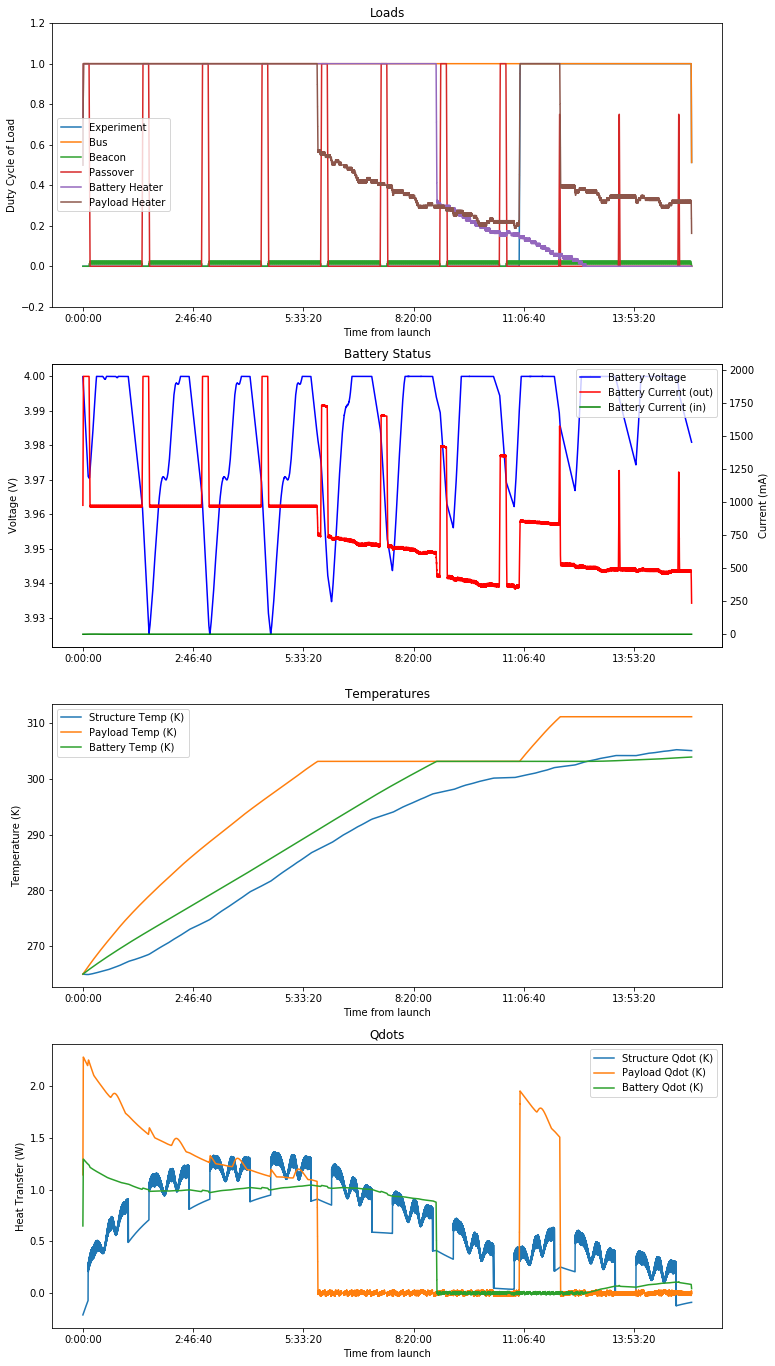

In [84]:
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(seconds=x)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = matplotlib.ticker.FuncFormatter(timeTicks)  

# need this so the plots make sense
smoothing_window = 80.0
smoothing_kernel = n.ones(int(smoothing_window))/smoothing_window

fig = figure(figsize=(12,24))
ax1 = subplot(4,1,1)
for load in states[0]['loads'].keys():
    plot(times,n.convolve([l['loads'][load][0] for l in states],smoothing_kernel, mode='same'), label=load)
legend()
ylim(-0.2,1.2)
title('Loads');
ylabel('Duty Cycle of Load')
xlabel("Time from launch")
                                                                                                                                                       
ax1.xaxis.set_major_formatter(formatter)  

ax1 = subplot(4,1,2)
ax2 = ax1.twinx()
l1 = ax1.plot(times,[s['batt_v'] for s in states], label='Battery Voltage', color='b')
l2 = ax2.plot(times,n.convolve([s['batt_current_out'] for s in states], smoothing_kernel,mode='same'), label='Battery Current (out)',color='r')                                                                                                                                                       
l3 = ax2.plot(times,n.convolve([s['batt_current_in'] for s in states], smoothing_kernel,mode='same'), label='Battery Current (in)',color='g')                                                                                                                                                       
ax1.xaxis.set_major_formatter(formatter)                                                                                                                                                                      
ax2.xaxis.set_major_formatter(formatter) 
xlabel("Time from launch")
ax1.set_ylabel("Voltage (V)")
ax2.set_ylabel("Current (mA)")

lines = l1+l2+l3
legend(lines,[l.get_label() for l in lines])
title('Battery Status');

ax1 = subplot(4,1,3)
ax1.plot(times,[s['temperatures']['structure'] for s in states], label='Structure Temp (K)')
ax1.plot(times,[s['temperatures']['payload'] for s in states], label='Payload Temp (K)')
ax1.plot(times,[s['temperatures']['battery'] for s in states], label='Battery Temp (K)')
legend()
title('Temperatures')  
xlabel("Time from launch")
ylabel('Temperature (K)')
ax1.xaxis.set_major_formatter(formatter)  

ax2 = subplot(4,1,4)
ax2.plot(times,[s['qdots']['structure'] for s in states], label='Structure Qdot (K)')
ax2.plot(times,n.convolve([s['qdots']['payload'] for s in states], smoothing_kernel,mode='same'), label='Payload Qdot (K)')
ax2.plot(times,n.convolve([s['qdots']['battery'] for s in states], smoothing_kernel,mode='same'), label='Battery Qdot (K)')
legend()
title('Qdots')    
xlabel("Time from launch") 
ylabel('Heat Transfer (W)')
ax2.xaxis.set_major_formatter(formatter)  